# Connecting Symuvia via Python 

This notebook explains the way a simple connection is created from `Python` towards `Symuvia`. In this case a simple simulation is run step by step and data is retrieved and stored within a `sqlite` file. At end data is imported and trajectories are plotted 

In [51]:
import os 
from ctypes import cdll, create_string_buffer, c_int, byref, c_bool


from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, String, Integer, Float 
from sqlalchemy import insert, delete, select, case, and_

from xmltodict import parse
from collections import OrderedDict, Counter

import pandas as pd
import matplotlib.pyplot as plt

# import altair as alt
# alt.renderers.enable('default')
# print(alt.renderers.active)

# from vega_datasets import data as data_vega

# import seaborn as sns

## Connect Symuvia 

In this case connect to the simulator. First define the `libSymuVia.dylib` file 

In [3]:
dir_path = os.getcwd()
lib_path_name = ('..','Symuvia','Contents','Frameworks','libSymuVia.dylib')

In [4]:
full_name = os.path.join(dir_path,*lib_path_name)

Load the lybrary

In [5]:
symuvialib = cdll.LoadLibrary(full_name)     

Determine the full path of the file to be simulated 

In [6]:
file_path = ('..', 'Network', 'Merge.xml')
file_name = os.path.join(dir_path, *file_path)

### Launching the symulation 

Load the network 

In [7]:
m = symuvialib.SymLoadNetworkEx(file_name.encode('UTF8'))

Check creation / load database 

In [8]:
engine_path = ('..','Output','SymOut.sqlite')
engine_name = os.path.join(os.path.sep,*engine_path)
engine_full_name = os.path.join(dir_path,*engine_path)
engine_call = 'sqlite://'+engine_name
engine = create_engine(engine_call)
metadata = MetaData()

if os.path.isfile(engine_full_name):
    try: 
        ltbstr = 'Loaded table in: '
        connection = engine.connect()    
        traj = Table('traj', metadata, autoload=True, autoload_with=engine)
        stmt = delete(traj)
        results = connection.execute(stmt)
    except:
        ltbstr = 'Loaded table in: '
        traj = Table('traj', metadata,
                 Column('ti', Float()),
                 Column('id', Integer()),
                 Column('type', String(3)),
                 Column('tron', String(10)),
                 Column('voie', Integer()),
                 Column('dst', Float()),
                 Column('abs', Float()),
                 Column('vit', Float()),
                 Column('ldr', Integer()),
                 Column('spc', Float()),
                 Column('vld', Float()))
        metadata.create_all(engine)
        connection = engine.connect()
    finally: 
        print(ltbstr, engine)

Loaded table in:  Engine(sqlite:///../Output/SymOut.sqlite)


Create pointers to retrieve data 

In [9]:
sRequest = create_string_buffer(10000)
bEnd = c_bool(False)
bSecond = c_bool(True)

Functions during running time 

In [10]:
# Parser data_vehicle
def typedict(veh_dict):
    data = {'id': int(veh_dict['@id']),
        'type': veh_dict['@type'],
        'tron': veh_dict['@tron'],
        'voie': int(veh_dict['@voie']),
        'dst': float(veh_dict['@dst']),
        'abs': float(veh_dict['@abs']),
        'vit': float(veh_dict['@vit']),
       }
    return data 

### Network information

Information regarding V2V communicatioin is computed. In particular which is the connectivity in this case only a single leader is identified 

In [11]:
# Identify Leader 

def queueveh(dLeader, veh):
    if veh['tron'] in dLeader.keys():
        if  veh['id'] not in dLeader[veh['tron']]:
            dLeader[veh['tron']].append(veh['id'])
    else:
        dLeader[veh['tron']] = [veh['id']]
    return dLeader 

def getlead(dLeader, veh):
    idx = dLeader[veh['tron']].index(veh['id'])
    if idx != 0:
        return dLeader[veh['tron']][idx-1]
    else: 
        return dLeader[veh['tron']][idx]
        

### Control information 

In this case functions to compute `spacing` and leaders' information is provided 

In [12]:
# Spacing 

def getspace(lTrajVeh):    
    try: 
        # Case single vehicle
        if lTrajVeh['id'] == lTrajVeh['ldr']:
            return [{'spc':0.0}] 
        else:
            # Last vehicle
            # Leader out of Network @ ti
            return [{'spc':None}] 
    except (TypeError, IndexError):        
        # Multiple veh @ ti
        space = []
        for veh in lTrajVeh:
            if veh['id'] == veh['ldr']:
                space.append(0.0)
            else:             
                veh_pos = veh['abs']
                ldr_id = veh['ldr']
                ldr_pos = [ldr['abs'] for ldr in lTrajVeh if ldr['id']==ldr_id]
                if ldr_pos:
                    space.append(ldr_pos[0]-veh_pos)
                else:
                    # Leader out of Network @ ti
                    space.append(0.0)
        space_dct = [{'spc': val} for val in space]
        return space_dct

def getleaderspeed(lTrajVeh):
    try: 
        # Case single vehicle
        if lTrajVeh['id'] == lTrajVeh['ldr']:
            return [{'vld': lTrajVeh['vit']}]
        else:
            # Leader out of Network @ ti
            return [{'vld':None}]                     
    except (TypeError, IndexError):        
        # Multiple veh @ ti
        speedldr = []
        for veh in lTrajVeh:
            if veh['id'] == veh['ldr']:
                speedldr.append(veh['vit'])
            else:             
                ldr_id = veh['ldr']
                ldr_vit = [ldr['vit'] for ldr in lTrajVeh if ldr['id']==ldr_id]
                if ldr_vit:
                    speedldr.append(ldr_vit[0])
                else:
                    speedldr.append(veh['vit'])
        speedldr_dct = [{'vld': val} for val in speedldr]
        return speedldr_dct    
    
def updatelist(lTrajVeh,lDict):
    try:
        lTrajVeh.update(lDict[0])
    except AttributeError:
        for d,s in zip(lTrajVeh,lDict):
            d.update(s)
    return lTrajVeh



Iterate step by step over the simulation

In [13]:
N = 500 # Simulation steps

# Start simulation from beginning
m = symuvialib.SymLoadNetworkEx(file_name.encode('UTF8'))

# Clean table
stmt = delete(traj)
results = connection.execute(stmt)

step = iter(range(N)) 
stmt = insert(traj)

t = []

#for step in steps: 
bSuccess = 2 
while bSuccess>0:
    try:
        next(step)
        bSuccess =  symuvialib.SymRunNextStepEx(sRequest, True, byref(bEnd))
        dParsed = parse(sRequest.value.decode('UTF8'))
        ti = dParsed['INST']['@val']
        if dParsed['INST']['TRAJS'] is None:
            print('No vehicles in the network at time: {}'.format(ti))
        else:            
            lVehOD = dParsed['INST']['TRAJS']['TRAJ']      
            lTrajVeh = []
            try:
                lTrajVeh = typedict(lVehOD)
                lTrajVeh['ti'] = ti
                dLeader = {lTrajVeh['tron']: [lTrajVeh['id']]}
                lTrajVeh['ldr'] = getlead(dLeader, lTrajVeh)                  
            except TypeError:
                # Multiple veh @ ti
                for i,  veh in enumerate(lVehOD):
                    TrajVeh = typedict(veh)
                    TrajVeh['ti'] = ti
                    dLeader = queueveh(dLeader, TrajVeh)
                    TrajVeh['ldr'] = getlead(dLeader, TrajVeh)
                    lTrajVeh.append(TrajVeh)
            lSpc = getspace(lTrajVeh)
            lLdrV = getleaderspeed(lTrajVeh)
            lTrajVeh = updatelist(lTrajVeh,lSpc)
            lTrajVeh = updatelist(lTrajVeh,lLdrV)
            results = connection.execute(stmt,lTrajVeh)
            # print('{} vehicles in the network at time: {}'.format(results.rowcount, ti))
          
        t.append(ti)
        
    except StopIteration:
        print('Stop by iteration')
        print('Last simluation step at time: {}'.format(ti))
        bSuccess = 0
    except:
        print('Return from Symuvia Empty: {}'.format(sRequest.value.decode('UTF8')))
        print('Last simluation step at time: {}'.format(ti))
        bSuccess = 0

No vehicles in the network at time: 0.10
No vehicles in the network at time: 0.20
No vehicles in the network at time: 0.30
No vehicles in the network at time: 0.40
No vehicles in the network at time: 0.50
No vehicles in the network at time: 0.60
No vehicles in the network at time: 0.70
No vehicles in the network at time: 0.80
No vehicles in the network at time: 0.90
No vehicles in the network at time: 1.00
No vehicles in the network at time: 1.10
No vehicles in the network at time: 1.20
No vehicles in the network at time: 42.70
No vehicles in the network at time: 42.80
No vehicles in the network at time: 42.90
No vehicles in the network at time: 43.00
No vehicles in the network at time: 43.10
No vehicles in the network at time: 43.20
No vehicles in the network at time: 43.30
No vehicles in the network at time: 43.40
No vehicles in the network at time: 43.50
No vehicles in the network at time: 43.60
No vehicles in the network at time: 43.70
No vehicles in the network at time: 43.80
No v

## Open loop: Results

This is to retrieve results from the launched simulation

In [14]:
stmt = select([traj])
print(stmt)
results = connection.execute(stmt).fetchall()

SELECT traj.ti, traj.id, traj.type, traj.tron, traj.voie, traj.dst, traj.abs, traj.vit, traj.ldr, traj.spc, traj.vld 
FROM traj


In [15]:
column_names = traj.columns.keys()
trajDf = pd.DataFrame(results, columns = column_names)
trajDf.head()

,ti,id,type,tron,voie,dst,abs,vit,ldr,spc,vld
0,1.3,0,CAV,In_main,1,1.25,-498.75,25.0,0,0.0,25.0
1,1.4,0,CAV,In_main,1,3.75,-496.25,25.0,0,0.0,25.0
2,1.5,0,CAV,In_main,1,6.25,-493.75,25.0,0,0.0,25.0
3,1.6,0,CAV,In_main,1,8.75,-491.25,25.0,0,0.0,25.0
4,1.7,0,CAV,In_main,1,11.25,-488.75,25.0,0,0.0,25.0


In [16]:
trajDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3736 entries, 0 to 3735
Data columns (total 11 columns):
ti      3736 non-null float64
id      3736 non-null int64
type    3736 non-null object
tron    3736 non-null object
voie    3736 non-null int64
dst     3736 non-null float64
abs     3736 non-null float64
vit     3736 non-null float64
ldr     3736 non-null int64
spc     3736 non-null float64
vld     3736 non-null float64
dtypes: float64(6), int64(3), object(2)
memory usage: 321.1+ KB


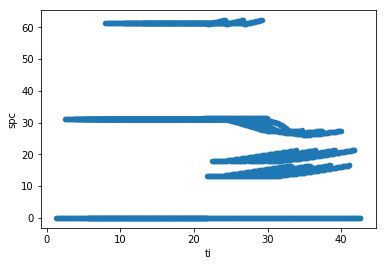

In [17]:
trajDf.plot(kind='scatter',x='ti',y ='spc')
plt.show()

Extracting data for control 

In [40]:
veh_type = trajDf.groupby('type').id.unique()
n_CAV = len(veh_type['CAV'])
n_HDV = len(veh_type['HDV'])
veh_type.head()

type
CAV    [0, 1, 2, 3, 5, 6, 8, 9]
HDV              [4, 7, 10, 11]
Name: id, dtype: object

### Control law 
 
In order to execute the control we follow the following approach. 

1. First update $\Delta v_{k+1} = \Delta v_{k} + \Delta u_{k}$. And $\Delta u_i = u_{i-1}-u_i$ in particular $\Delta u_0 = u_{ref}-u_{0}$
2. At the level of code, a vehicle can be: 
    * **Platoon**: $u_{i-1}$ is known $\Delta v_{k} $ can be computed. The key is $\Delta v_k$
    * **Non platoon**: $u_{i-1}$ is unknown, then an input pattern should be provided. 
    * **Following unconnected**: $u_{i-1}$ is unknown, but because of car-following model it is not required. The update sequence in time is different. 
3. When solving the control problem we can think about the following idea. 
    * The problem regularly is solved by **road** 
        ```python
        for i in roads: 
            detect_vehicles_in_road(i)
            solve_control_in_road(i)
            apply_control_in_road(i)
        ```
    * Although we may think that the control strategy is solved distributely the key concept is:
        * Compute the leader information 
        * Compute followers **at same time**. Use matrix operations for this 
        ```python
        def solve_control_in_road(i)
            if cav_veh(i)
                v = get_cav_veh()
                u = solve_control(v)
            else 
                u = 0 # Value to force the car-following model
            return u 
        ```
        * Apply $u$

### Creation table of results 

The following table will contain the results of simulation 

In [18]:
if os.path.isfile(engine_full_name):
    try:
        ltbstr = 'Loaded table in: '
        connection = engine.connect()    
        control = Table('control', metadata, autoload=True, autoload_with=engine)
        stmt = delete(control)
        results = connection.execute(stmt)
    except:
        ltbstr = 'Created table in: '
        control = Table('control', metadata,
                 Column('ti', Float()),
                 Column('id', Integer()),
                 Column('type', String(3)),
                 Column('tron', String(10)),
                 Column('voie', Integer()),
                 Column('dst', Float()),
                 Column('abs', Float()),
                 Column('vit', Float()),
                 Column('ldr', Integer()),
                 Column('spc', Float()),
                 Column('vld', Float()),
                 Column('ctr', Float()))
        metadata.create_all(engine)
        connection = engine.connect()
    finally: 
        print(ltbstr, engine)
                

Loaded table in:  Engine(sqlite:///../Output/SymOut.sqlite)


In [46]:
%%time 

N = 200 # Simulation steps

t_it = iter(t)
step = iter(range(N)) 

bSuccess = 2 
while bSuccess>0:
    try: 
        t_i = next(t_it)
        next(step)
        
        # Query results 
        stmt = select([traj]).where(traj.columns.ti==t_i)
        results = connection.execute(stmt).fetchall()
        
        # Check vehicle creation
        
    
    except StopIteration:
        print('Stop by iteration')
        print('Last simluation step at time: {}'.format(t_i))
        bSuccess = 0

Stop by iteration
Last simluation step at time: 20.10
CPU times: user 249 ms, sys: 8.75 ms, total: 258 ms
Wall time: 259 ms
